In [11]:
import numpy as np
from scipy.interpolate import interp1d

def f_varphimat(lam_discr, gb):
    L = len(lam_discr)
    varphi = lambda lam: 2 * gb / (gb**2 + lam**2)
    varphimat = np.zeros((L, L))

    for i in range(L):
        for j in range(i+1):
            varphimat[i, j] = varphi(lam_discr[i] - lam_discr[j])
            varphimat[j, i] = varphi(lam_discr[i] - lam_discr[j])

    varphimat = np.triu(varphimat) + np.triu(varphimat, 1).T
    return varphimat

def f_dlam(lam_discr):
    L = len(lam_discr)
    dlam = np.zeros(L)
    
    for i in range(1, L-1):
        dlam[i] = 0.5 * (lam_discr[i+1] - lam_discr[i-1])
    dlam[0] = 0.5 * (lam_discr[1] - lam_discr[0])
    dlam[-1] = 0.5 * (lam_discr[-1] - lam_discr[-2])
    return dlam

def dress(gb, lam_discr, n_discr, f_discr):
    varphimat = f_varphimat(lam_discr, gb)
    dlam = f_dlam(lam_discr)
    A = np.eye(len(lam_discr)) - 0.5/np.pi * varphimat * np.diag(n_discr) * np.diag(dlam)
    return np.linalg.solve(A, f_discr)

def charge_density(gb, lam_discr, n_discr, f_discr):
    varphimat = f_varphimat(lam_discr, gb)
    dlam = f_dlam(lam_discr)
    A = np.eye(len(lam_discr)) - 0.5/np.pi * varphimat * np.diag(n_discr) * np.diag(dlam)
    return 0.5/np.pi * np.dot(dlam, np.diag(n_discr) @ np.linalg.solve(A, f_discr))

def fun1(z):
    return np.where(z > 0, np.log(1. + np.exp(-z)), np.log(1. + np.exp(z)) - z)

def fun2(z):
    return np.where(z < 0, 1. / (1. + np.exp(z)), np.exp(-z) / (1. + np.exp(-z)))

def yangyang(gb, beta, lam_discr):
    varphimat = f_varphimat(lam_discr, gb)
    dlam = f_dlam(lam_discr)
    bare_E = 0.5 * beta[2] * lam_discr**2 + beta[1] * lam_discr + beta[0] * np.ones(len(lam_discr))
    eps = np.copy(bare_E)
    n = fun2(eps)

    # Iterative solution
    diff = 1.
    while diff > 1e-12:
        old_n = np.copy(n)
        eps = bare_E - 0.5/np.pi * varphimat @ np.diag(fun1(eps)) @ dlam
        n = fun2(eps)
        diff = np.linalg.norm(n - old_n)
    return n

def veff(gb, lam_discr, n_discr):
    varphimat = f_varphimat(lam_discr, gb)
    dlam = f_dlam(lam_discr)
    dresser = np.eye(len(lam_discr)) - 0.5/np.pi * varphimat @ np.diag(n_discr) @ np.diag(dlam)
    onedr = np.linalg.solve(dresser, np.ones(len(lam_discr)))
    iddr = np.linalg.solve(dresser, np.copy(lam_discr))
    return iddr / onedr

def evol_box_expansion(dt, x1, x2, gb, theta_tab, n_fun):
    npts_integral = 600
    L = len(x1)
    veff1 = np.zeros(L)
    veff2 = np.zeros(L)
    f2 = interp1d(x2, theta_tab)
    f1 = interp1d(x1, theta_tab)
    veff1[0] = theta_tab[0]
    veff2[-1] = theta_tab[-1]

    for j in range(1, L):
        thet1 = theta_tab[j]
        thet2 = theta_tab[0] if x1[j] < x2[0] else f2(x1[j])
        lam_discr = np.linspace(thet2, thet1, npts_integral)
        n_discr = n_fun(lam_discr)
        veff1[j] = veff(gb, lam_discr, n_discr)[-1]

    for j in range(L-1):
        thet1 = theta_tab[j]
        thet2 = theta_tab[-1] if x2[j] > x1[-1] else f1(x2[j])
        lam_discr = np.linspace(thet1, thet2, npts_integral)
        n_discr = n_fun(lam_discr)
        veff2[j] = veff(gb, lam_discr, n_discr)[0]

    return x1 + dt * veff1, x2 + dt * veff2

def eval_density(x1, x2, gb, theta_tab, n_fun, ratio_m_hbar):
    L = len(x1)
    dens = np.zeros((2, 2*L))
    f2 = interp1d(x2, theta_tab)
    f1 = interp1d(x1, theta_tab)
    dens[0, 0] = x1[0]
    dens[1, 0] = 0
    dens[0, L] = x2[-1]
    dens[1, L] = 0

    for j in range(1, L):
        thet1 = theta_tab[j]
        thet2 = theta_tab[0] if x1[j] < x2[0] else f2(x1[j])
        lam_discr = np.linspace(thet2, thet1, 600)
        n_discr = n_fun(lam_discr)
        dens[0, j] = x1[j]
        dens[1, j] = ratio_m_hbar * charge_density(gb, lam_discr, n_discr, np.ones(len(lam_discr)))

    for j in range(L-1):
        thet1 = theta_tab[j]
        thet2 = theta_tab[-1] if x2[j] > x1[-1] else f1(x2[j])
        lam_discr = np.linspace(thet1, thet2, 600)
        n_discr = n_fun(lam_discr)
        dens[0, 2*L-1-j] = x2[j]
        dens[1, 2*L-1-j] = ratio_m_hbar * charge_density(gb, lam_discr, n_discr, np.ones(len(lam_discr)))

    idx = np.argsort(dens[0, :])
    return dens[:, idx]

def box_expansion(n_fun, dt, list_t_save, theta_max, npts, gb, ratio_m_hbar):
    tmax = max(list_t_save)
    theta_tab = np.linspace(-theta_max, theta_max, npts)
    x1 = -0.5 * np.ones(npts) + 0.0000001 * theta_tab
    x2 = 0.5 * np.ones(npts) + 0.0000001 * theta_tab
    t = 0
    
    while t <= tmax:
        x1, x2 = evol_box_expansion(dt, x1, x2, gb, theta_tab, n_fun)
        t += dt

        for ts in list_t_save:
            if t - dt < ts <= t:
                mydensity = eval_density(x1, x2, gb, theta_tab, n_fun, ratio_m_hbar)
                print("t = %.3f saved" % t)
                filename = "density_expansion_n_theta_etoile_py_%.3f_%.3f_%.3f_%.3f.npz" % (mup / kB, T, Taille, t)
                np.savez(filename, mydensity)


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_triangular
from scipy.interpolate import interp1d
from scipy.optimize import brentq

def DeltaMat(theta_discr, gbar):
    L = len(theta_discr)
    varphi = lambda theta: 2 * gbar / (gbar**2 + theta**2)
    varphimat = np.zeros((L, L))

    for i in range(L):
        for j in range(i+1):
            varphimat[i, j] = varphi(theta_discr[i] - theta_discr[j])
            varphimat[j, i] = varphi(theta_discr[i] - theta_discr[j])

    varphimat = np.triu(varphimat) + np.triu(varphimat, 1).T
    return varphimat

def Delta(theta_discr):
    L = len(theta_discr)
    dtheta = np.zeros(L)

    for i in range(1, L-1):
        dtheta[i] = 0.5 * (theta_discr[i+1] - theta_discr[i-1])
    dtheta[0] = 0.5 * (theta_discr[1] - theta_discr[0])
    dtheta[-1] = 0.5 * (theta_discr[-1] - theta_discr[-2])

    return dtheta

def montrer_les_rho(theta_discr, nu_discr, gbar):
    L = len(theta_discr)
    varphimat = DeltaMat(theta_discr, gbar)
    dtheta = Delta(theta_discr)
    plt.figure(figsize=(10, 6))

    # Plot nu_tilde
    plt.plot(theta_discr, nu_discr, label='$\\tilde{\\nu}$')

    # Méthode 0
    rho_s_0 = 0.5 / np.pi * dress(gbar, theta_discr, nu_discr, np.ones(L))
    rho_0 = nu_discr * rho_s_0
    plt.plot(theta_discr, rho_s_0, label='Meth 0: $\\tilde{\\rho_s}= \\frac{1}{2\\pi}$')
    plt.plot(theta_discr, rho_0, label='Meth 0: $\\tilde{\\rho}= \\tilde{\\nu} * \\tilde{\\rho_s}$')

    # Méthode 1
    Mat_F_1 = np.eye(L) - (1 / (2 * np.pi)) * np.diag(dtheta) @ np.diag(nu_discr) @ varphimat
    B = (1 / (2 * np.pi)) * nu_discr
    rho_1 = solve_triangular(Mat_F_1, B)
    rho_s_1 = rho_1 / nu_discr
    plt.plot(theta_discr, rho_1, label='Meth 1: $\\tilde{\\rho}= \\frac{\\tilde{\\nu}}{2\\pi} ( 1 + \\tilde{\\Delta} * \\tilde{\\rho}) $')
    plt.plot(theta_discr, rho_s_1, label='Meth 1: $\\tilde{\\rho}_s  = \\frac{\\tilde{\\rho}}{\\tilde{\\nu}}$')

    # Méthode 2
    Mat_F_2 = np.eye(L) - 0.5 / np.pi * varphimat @ np.diag(nu_discr) @ np.diag(dtheta)
    B = (1 / (2 * np.pi)) * np.ones(L)
    rho_s_2 = solve_triangular(Mat_F_2, B)
    rho_2 = nu_discr * rho_s_2
    plt.plot(theta_discr, rho_s_2, label='Meth 2: $\\tilde{\\rho_s}= \\frac{1}{2\\pi}$')
    plt.plot(theta_discr, rho_2, label='Meth 2: $\\tilde{\\rho}= \\tilde{\\nu} * \\tilde{\\rho_s}$')

    plt.xlabel('$\\tilde{\\theta}$')
    plt.ylabel('$f$')
    plt.legend(loc='upper right')
    plt.show()

def find_nu_theta_star_discr(theta_discr, theta_star, nu_discr):
    return np.where(theta_discr > theta_star, 0, nu_discr)

def find_theta_star(theta_discr, nu_discr, gbar):
    # Définition de la fonction f_veff_star_theta_star
    def f_veff_star_theta_star(theta_star):
        return interp1d(theta_discr, veff(gbar, theta_discr, find_nu_theta_star_discr(theta_discr, theta_star, nu_discr)))(theta_star)
    
    return brentq(f_veff_star_theta_star, theta_discr[0], theta_discr[-1])


In [13]:
import os
from datetime import date

# Get today's date
today = date.today()

# Format the date according to the specified format
new_date = today.strftime("%Y-%m-%d")

# Create the directory
if not os.path.isdir(new_date):
    os.mkdir(new_date)

# Display the formatted date
print(new_date)


2024-03-05


In [14]:
import os

new_date = "test"

# Create the directory
if not os.path.isdir(new_date):
    os.mkdir(new_date)

# Display the date
print(new_date)


test


In [15]:
import numpy as np

# Définir les constantes
hbar = 1.05457182e-25   # um^2.kg/ms
mass =  1.44e-25        # kg (mass of Rubidium 87)
kB = 1.380649e-26       # um^2.ms^-2.kg.nK^{-1}
a3D = 5.3e-3            # um
om_perp = 2 * np.pi * 2.56  # kHz (transverse frequency)

# Calculer les constantes dérivées
g = 2 * hbar * a3D * om_perp        # effective 1d repulsion strength
c = mass / hbar**2 * g              # um^{-1}
gbar = g / hbar                   # um.ms^{-1}

print(g*45/kB)

lam_discr = np.linspace(-100, 100, 600)
# Note: This part needs to be translated based on the implementation of f_varphimat function in Python

import time

# Start the timer
start_time = time.time()

# Call the function
varphimat = f_varphimat(lam_discr, gbar)

# End the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print("Elapsed time:", elapsed_time, "seconds")


58.60451714829708
Elapsed time: 0.4342765808105469 seconds


In [16]:
# Fonction pour sauvegarder nu, rho et rho_s
def save_nu_rho_rho_s(new_date, nom, theta_discr, n_p, mup, T, Taille, gbar):
    if mup == "None":
        mup = hbar * om_perp * (np.sqrt(1 + 4 * n_p * a3D) - 1)   # kg um^2.ms^-1
    else:
        n_p = (((mup / (hbar * om_perp)) + 1)**2 - 1) / (4 * a3D)

    # Discrétisation de theta
    beta = [-mup / (kB * T), 0, mass / (kB * T)]

    # Définir la date sous forme de chaîne
    filename = f"{new_date}/theta_discr_{nom[nom.rfind('_')+1:]}.npz"
    np.savez(filename, theta_discr)
    print("saved:", filename)  

    nu_discr = yangyang(gbar, beta, theta_discr)
    filename = f"{new_date}/nu_discr_{nom[nom.rfind('_')+1:]}_{mup/kB}_{T}.npz"
    np.savez(filename, nu_discr)
    print("saved:", filename)

    rho_s_discr = 0.5 / np.pi * mass / hbar * dress(gbar, theta_discr, nu_discr, np.ones_like(theta_discr))
    filename = f"{new_date}/rho_s_discr_{nom[nom.rfind('_')+1:]}_{mup/kB}_{T}.npz"
    np.savez(filename, rho_s_discr)
    print("saved:", filename)

    rho_discr = nu_discr * rho_s_discr
    filename = f"{new_date}/rho_discr_{nom[nom.rfind('_')+1:]}_{mup/kB}_{T}.npz"
    np.savez(filename, rho_discr)
    print("saved:", filename)

    theta_star = find_theta_star(theta_discr, nu_discr, gbar)
    filename = f"{new_date}/{nom}_{mup/kB}_{T}.npz"
    np.savez(filename, theta_star)
    print("saved:", filename)

    nu_theta_star_discr = find_nu_theta_star_discr(theta_discr, theta_star, nu_discr)
    filename = f"{new_date}/nu_{nom[:nom.rfind('_')]}_discr_{nom[nom.rfind('_')+1:]}_{mup/kB}_{T}.npz"
    np.savez(filename, nu_theta_star_discr)
    print("saved:", filename)

    return theta_discr, nu_discr, rho_s_discr, rho_discr, theta_star, nu_theta_star_discr


In [39]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def pre_model_fit_homo(new_date, nom, theta_discr, n_p, mup, T, Taille, gbar):

    def box_expansion(nu_fun, dt, list_t_save, theta_max, npts, gb, ratio_m_hbar):

        filename0 = f"{new_date}/density_expansion_nu_julia_{mup/kB:.3f}_{T:.3f}_{Taille:.3f}_"
        filename0 = f"{new_date}/density_expansion_nu_{nom}_{mup/kB:.3f}_{T:.3f}_{Taille:.3f}_"

        tmax = max(list_t_save)
        theta_tab = np.linspace(-theta_max, theta_max, npts)
        x1 = -0.5 * np.ones(npts) + 0.0000001 * theta_tab
        x2 = 0.5 * np.ones(npts) + 0.0000001 * theta_tab

        mydensity = eval_density(x1, x2, gb, theta_tab, nu_fun, ratio_m_hbar)
        print("t = {:.3f} saved".format(0))
        filename = filename0 + "{:.3f}.npz".format(0)
        print("saved:", filename)
        np.savez(filename, mydensity)

        while t <= tmax:
            x1, x2 = evol_box_expansion(dt, x1, x2, gb, theta_tab, nu_fun)
            t += dt

            for ts in list_t_save:
                if t - dt <= ts <= t:
                    mydensity = eval_density(x1, x2, gb, theta_tab, nu_fun, ratio_m_hbar)
                    print("t = {:.3f} saved".format(t))
                    filename = filename0 + "{:.3f}.npz".format(t * Taille)
                    print("saved:", filename)
                    np.savez(filename, mydensity)

        plt.plot(mydensity[0, :], mydensity[1, :])
        plt.xlabel('x')
        plt.ylabel('n')
        plt.legend(['Density'])
        plt.show()
        return mydensity[0, :], mydensity[1, :]

    theta_discr, nu_discr, rho_s_discr, rho_discr, theta_star, nu_theta_star_discr = save_nu_rho_rho_s(new_date, nom, theta_discr, n_p, mup, T, Taille, gbar)
    
    nu_fun = interp1d(theta_discr, nu_theta_star_discr)

    temps_sav = [50.0 / Taille]
    dt = 50 / Taille
    return box_expansion(nu_fun, dt, temps_sav, theta_max, npts, gbar, mass / hbar)

theta_max = 20 
npts = 200
nom = "theta_star_1.0_h"
theta_discr = np.linspace(-theta_max, theta_max, npts)

def model_fit_homo(x, *p):
    mup, T = p[0] * kB, p[1]
    n_p = "None"
    print("mup = {:.3f}".format(mup / kB))
    print("T = {:.3f}".format(T))
    theta_discr = np.linspace(-theta_max, theta_max, npts)
    theta_discr, nu_discr, rho_s_discr, rho_discr, theta_star, nu_theta_star_discr = save_nu_rho_rho_s(new_date, nom, theta_discr, n_p, mup, T, Taille, gbar)
    nu_fun = interp1d(theta_discr, nu_theta_star_discr)

    x_simul, y_simul = pre_model_fit_homo(new_date, nom, theta_discr, n_p, mup, T, Taille, gbar)
    density_fun = interp1d(x_simul, y_simul)

    plt.plot(x, density_fun(x))
    plt.xlabel('xxx')
    plt.ylabel('n')
    plt.legend(['Density'])
    plt.show()
    return density_fun(x)


In [40]:
date_donnees = '2024-02-29'

DONNEES = []

if date_donnees == 'None' :
    #DONNEES = [[[[1,2],[1,2],'None']]*3]
    fichier_x = "Scan43_coupure2_1ms_x.txt"
    fichier_y = "Scan43_coupure2_1ms_n.txt"
    Donnees = [np.loadtxt(f"{'2024-02-05'}/Donnees/{fichier_x}") , np.flip(np.loadtxt(f"{'2024-02-05'}/Donnees/{fichier_y}"))*0 , '2em coupure $1ms$']
    DONNEES.append(Donnees)
    fichier_x = "Scan43_coupure1_10ms_x.txt"
    fichier_y = "Scan43_coupure1_10ms_n.txt"
    Donnees = [np.loadtxt(f"{'2024-02-05'}/Donnees/{fichier_x}") , np.flip(np.loadtxt(f"{'2024-02-05'}/Donnees/{fichier_y}"))*0 , '1er coupure $10 ms$']
    DONNEES.append(Donnees)
    fichier_x = "Scan43_x.txt"
    fichier_y = "Scan43_n.txt"
    Donnees = [np.loadtxt(f"{'2024-02-05'}/Donnees/{fichier_x}") , np.flip(np.loadtxt(f"{'2024-02-05'}/Donnees/{fichier_y}"))*0 , '2em coupure $40 ms$']
    DONNEES.append(Donnees)

if date_donnees == '2024-02-05' :
    fichier_x = "Scan43_coupure2_1ms_x.txt"
    fichier_y = "Scan43_coupure2_1ms_n.txt"
    Donnees = [np.loadtxt(f"{date_donnees}/Donnees/{fichier_x}") , np.flip(np.loadtxt(f"{date_donnees}/Donnees/{fichier_y}")) , '2em coupure $1ms$']
    DONNEES.append(Donnees)
    fichier_x = "Scan43_coupure1_10ms_x.txt"
    fichier_y = "Scan43_coupure1_10ms_n.txt"
    Donnees = [np.loadtxt(f"{date_donnees}/Donnees/{fichier_x}") , np.flip(np.loadtxt(f"{date_donnees}/Donnees/{fichier_y}")) , '1er coupure $10 ms$']
    DONNEES.append(Donnees)
    fichier_x = "Scan43_x.txt"
    fichier_y = "Scan43_n.txt"
    Donnees = [np.loadtxt(f"{date_donnees}/Donnees/{fichier_x}") , np.flip(np.loadtxt(f"{date_donnees}/Donnees/{fichier_y}")) , '2em coupure $40 ms$']
    DONNEES.append(Donnees)
    
elif date_donnees == '2024-02-09' :
    fichier_x = "X_Scan704_18ms.txt"
    fichier_y = "Y_Scan704_18ms.txt"
    Donnees = [-np.loadtxt(f"{date_donnees}/Donnees/{fichier_x}") , np.loadtxt(f"{date_donnees}/Donnees/{fichier_y}") , 'Première coupure expansion $18~ms$']
    DONNEES.append(Donnees)
    fichier_x = "X_Scan696_1ms.txt"
    fichier_y = "Y_Scan696_1ms.txt"
    Donnees = [-np.loadtxt(f"{date_donnees}/Donnees/{fichier_x}") , np.loadtxt(f"{date_donnees}/Donnees/{fichier_y}") , 'Seconde coupure sélection $1~ ms$']
    DONNEES.append(Donnees)
    fichier_x = "X_Scan696_50ms.txt"
    fichier_y = "Y_Scan696_50ms.txt"
    Donnees = [-np.loadtxt(f"{date_donnees}/Donnees/{fichier_x}") , np.loadtxt(f"{date_donnees}/Donnees/{fichier_y}") , 'Seconde coupure expansion $50~ ms$']
    DONNEES.append(Donnees)
    
elif date_donnees == '2024-02-29' :
    fichier_x = "X_coupure1_1ms.txt"
    fichier_y = "Y_coupure1_1ms.txt"
    Donnees = [-np.loadtxt(f"{date_donnees}/Donnees/{fichier_x}") , np.loadtxt(f"{date_donnees}/Donnees/{fichier_y}") , 'coupure 1 $1~ms$']
    DONNEES.append(Donnees)
    fichier_x = "X_coupure1_28ms.txt"
    fichier_y = "Y_coupure1_28ms.txt"
    Donnees = [-np.loadtxt(f"{date_donnees}/Donnees/{fichier_x}") , np.loadtxt(f"{date_donnees}/Donnees/{fichier_y}") , 'coupure 1 $18~ms$']
    DONNEES.append(Donnees)
    fichier_x = "X_coupure2_1ms.txt"
    fichier_y = "Y_coupure2_1ms.txt"
    Donnees = [-np.loadtxt(f"{date_donnees}/Donnees/{fichier_x}") , np.loadtxt(f"{date_donnees}/Donnees/{fichier_y}") , 'coupure 2 $1~ms$']
    DONNEES.append(Donnees)
    fichier_x = "X_coupure2_50ms.txt"
    fichier_y = "Y_coupure2_50ms.txt"
    Donnees = [-np.loadtxt(f"{date_donnees}/Donnees/{fichier_x}") , np.loadtxt(f"{date_donnees}/Donnees/{fichier_y}") , 'coupure 2 $50~ms$']
    DONNEES.append(Donnees)

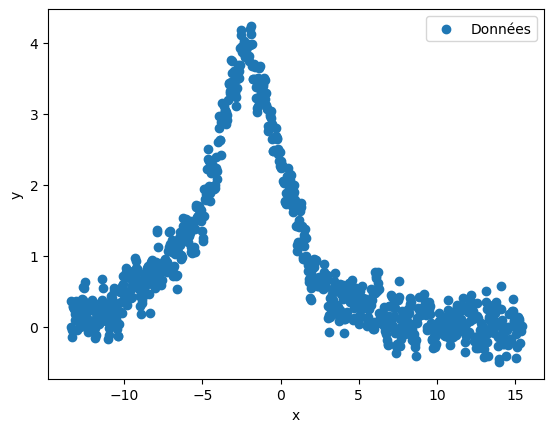

lower_bounds = [ 24.5 100. ]
upper_bounds = [ 73.5 300. ]
mup = 49.000
T = 200.000
saved: test/theta_discr_h.npz
saved: test/nu_discr_h_49.0_200.0.npz
saved: test/rho_s_discr_h_49.0_200.0.npz
saved: test/rho_discr_h_49.0_200.0.npz
saved: test/theta_star_1.0_h_49.0_200.0.npz
saved: test/nu_theta_star_1.0_discr_h_49.0_200.0.npz
saved: test/theta_discr_h.npz
saved: test/nu_discr_h_49.0_200.0.npz
saved: test/rho_s_discr_h_49.0_200.0.npz
saved: test/rho_discr_h_49.0_200.0.npz
saved: test/theta_star_1.0_h_49.0_200.0.npz
saved: test/nu_theta_star_1.0_discr_h_49.0_200.0.npz
t = 0.000 saved
saved: test/density_expansion_nu_theta_star_1.0_h_49.000_200.000_50.000_0.000.npz


UnboundLocalError: local variable 't' referenced before assignment

In [41]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


# Taille en um
Taille = 50

x_data = DONNEES[-1][0] / Taille
y_data = DONNEES[-1][1]

# Tracer les données
plt.scatter(x_data, y_data, label="Données")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# Paramètres initiaux
p0 = [49.0, 200.0]

# Bornes des paramètres
lower_bounds = np.array(p0) * 0.5
upper_bounds = np.array(p0) * 1.5

# Afficher les bornes
print("lower_bounds =", lower_bounds)
print("upper_bounds =", upper_bounds)

# Effectuer l'ajustement avec bornes
fit_params, fit_covariance = curve_fit(model_fit_homo, x_data, y_data, p0=p0)#, bounds=(lower_bounds, upper_bounds))
